# Práctica 1 - Red Neuronal

### Utilidades

#### Configuración del dispositivo de cómputo
Selecciona automáticamente GPU si está disponible, o CPU en caso contrario, e imprime el dispositivo usado para entrenar la red.

In [61]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Usando dispositivo:", DEVICE)

Usando dispositivo: cuda


#### Fijación de semilla para reproducibilidad
La siguiente función, `seed_everything`, asegura que los experimentos sean reproducibles fijando la semilla para PyTorch, CUDA, NumPy y el generador de números aleatorios de Python. También configura CUDA para un comportamiento determinista cuando se usa GPU.

In [ ]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Preparación de datasets y dataloaders
La función `prepare_dataloaders` utiliza TensorFlow/Keras para cargar imágenes desde un directorio (dataset_path), dividiéndolas en conjuntos de entrenamiento, validación y prueba basándose en la estructura de subdirectorios (train, val y test). 

Aplica un preprocesamiento básico a las imágenes, como redimensionarlas a $48 \times 48$ píxeles, convertirlas a escala de grises (o el modo de color especificado), y las organiza en lotes (batch_size=64). 

Además, utiliza la codificación one-hot (label_mode='categorical') para las etiquetas, mezcla el conjunto de entrenamiento (shuffle=True) para asegurar la aleatoriedad, y aplica optimizaciones de carga de datos (cache().prefetch()) para mejorar la velocidad del entrenamiento.

In [ ]:
import tensorflow as tf
import os

def prepare_dataloaders(dataset_path: str,
                           batch_size=64,
                           img_size=(48, 48),
                           color_mode='grayscale'): 
    
    train_dir = os.path.join(dataset_path, 'train')
    val_dir = os.path.join(dataset_path, 'val') 
    test_dir = os.path.join(dataset_path, 'test') 

    # Carga entrenamiento
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical', # Importante para categorical_crossentropy
        color_mode=color_mode,
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=42
    )

    # Carga validación
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode=color_mode,
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )

    # Carga test
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode=color_mode,
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )

    classes = train_ds.class_names
    
    # Optimización de carga (cache y prefetch)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds, classes

#### Gráfico de las curvas de accuracy durante el entrenamiento y la validación de la red neuronal.
A continuación, se definirá una función que muestre cómo cambian la pérdida (loss) y la precisión (accuracy) del modelo en entrenamiento y validación a lo largo de las épocas. Esto permite evaluar el aprendizaje de la red, detectar overfitting o underfitting, y comparar el desempeño entre diferentes configuraciones del modelo.

La precisión se calcula como:
$$
\text{Accuracy} = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}} \times 100\%
$$

In [94]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    if history is None:
        return
    
    plt.figure(figsize=(12, 5))
    
    # Gráfico de Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.get('train_loss', []), label='Train Loss')
    plt.plot(history.get('val_loss', []), label='Val Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Gráfico de Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.get('train_acc', []), label='Train Acc')
    plt.plot(history.get('val_acc', []), label='Val Acc')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

#### Matriz de confusión
Asimismo, la siguiente función muestra la comparación entre las etiquetas reales (`y_true`) y las predicciones del modelo (`y_pred`) para cada clase. Permite identificar qué clases se confunden entre sí y evaluar detalladamente el desempeño del modelo en clasificación.

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    if y_true is None or y_pred is None:
        return

    # Asegurar que son arrays de numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()
    plt.show()

#### Guardar campos en el CSV

In [ ]:
import json
import pandas as pd
import os

def save_results(all_results):
    if not all_results:
        print("No se realizaron experimentos para guardar.")
        return

    # Convertir history_dict, y_true y y_pred a JSON string para guardarlo en CSV
    df_results = pd.DataFrame(all_results)

    df_results["history_dict"] = df_results["history_dict"].apply(json.dumps)
    df_results["y_true"] = df_results["y_true"].apply(lambda x: json.dumps(x.tolist()))
    df_results["y_pred"] = df_results["y_pred"].apply(lambda x: json.dumps(x.tolist()))

    # Duplicado de df sin columnas internas para visualización
    df_csv = df_results.T
    csv_filename = "resultados_cnn_fer.csv"

    # Convertir decimales '.' → ','
    def decimal_to_comma(df):
        return df.applymap(
            lambda x: str(x).replace('.', ',') if isinstance(x, (float, int)) else x
        )

    # Guardar o añadir
    if not os.path.exists(csv_filename):
        df_to_save = decimal_to_comma(df_csv)
        df_to_save.to_csv(csv_filename, sep=';', index=True)
    else:
        df_prev = pd.read_csv(csv_filename, sep=';', index_col=0)
        df_new = decimal_to_comma(df_csv)
        df_combined = pd.concat([df_prev, df_new], axis=0)
        df_combined.to_csv(csv_filename, sep=';', index=True)

    print(f"Resultados guardados en: {csv_filename}\n")


#### Leer desde el CSV

In [97]:
def robust_json_load(x):
    """
    Intenta cargar JSON de forma estricta. Si falla, intenta corregir
    formatos comunes (comillas simples, booleanos de Python, etc.)
    usando ast.literal_eval.
    """
    if not isinstance(x, str):
        return x
    try:
        return json.loads(x)
    except (json.JSONDecodeError, TypeError):
        try:
            # Reemplazos para hacer compatible string formato Python con JSON/eval
            x_fixed = x.replace("null", "None").replace("true", "True").replace("false", "False")
            return ast.literal_eval(x_fixed)
        except Exception as e:
            print(f"Error decodificando: {e}")
            return None

def load_all_experiments_from_csv(csv_filename):
    # 1. Leer con el separador correcto (punto y coma según tu archivo)
    df = pd.read_csv(csv_filename, sep=';', index_col=0)
    
    # 2. Transponer (Filas = Experimentos)
    df = df.T
    
    # 3. Convertir columnas JSON de forma robusta
    json_cols = ["history_dict", "y_true", "y_pred"]
    for col in json_cols:
        if col in df.columns:
            df[col] = df[col].apply(robust_json_load)
            
    # 4. Convertir test_acc a float manejando la coma decimal
    if "test_acc" in df.columns:
        # Reemplaza ',' por '.' y convierte a float
        df["test_acc"] = df["test_acc"].astype(str).str.replace(',', '.').astype(float)
        
    return df

#### Analizar mejor y peor experimento

In [92]:
def analyze_from_csv(csv_filename, classes):
    # Cargar datos
    df = load_all_experiments_from_csv(csv_filename)

    # Identificar mejor y peor experimento
    best = df.loc[df["test_acc"].idxmax()]
    worst = df.loc[df["test_acc"].idxmin()]

    print(f"🏆 Mejor experimento: {best['name']} - {best['test_acc']}%")
    print(f"📉 Peor experimento: {worst['name']} - {worst['test_acc']}%")

    # Graficar Mejor
    plot_training_history(best["history_dict"], title=f"Mejor experimento")
    plot_confusion_matrix(best["y_true"], best["y_pred"], classes, f"Confusion ({best['name']})")

    # Graficar Peor
    plot_training_history(worst["history_dict"], title=f"Peor experimento")
    plot_confusion_matrix(worst["y_true"], worst["y_pred"], classes, f"Confusion ({worst['name']})")

### Entrenamiento CNN desde cero

#### Modelo

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, Input, LeakyReLU
)
from tensorflow.keras.optimizers import Adam


def build_modular_cnn(
    input_shape=(48, 48, 1),
    conv_layers=[(64,3,1), (128,3,1), (256,3,2)],
    fc_layers=[256,128],
    dropout_conv=0.3,
    dropout_fc=0.4,
    num_classes=7,
    activation=LeakyReLU,   
    lr=1e-3
):
    """
    Crea un modelo CNN modular tipo FER, basado en:
    conv_layers = [(filters, kernel_size, repeats), ...]
    fc_layers   = [n1, n2, ...]
    """

    model = Sequential()
    
    model.add(Input(shape=input_shape))
    model.add(Rescaling(1./255))

    # ----- BLOQUES CONVOLUCIONALES -----
    for filters, k, reps in conv_layers:
        for _ in range(reps):
            model.add(Conv2D(filters, (k, k), padding="same"))
            model.add(activation())   
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(dropout_conv))

    # ----- CAPAS DENSAS -----
    model.add(Flatten())

    for units in fc_layers:
        model.add(Dense(units))
        model.add(activation())
        model.add(Dropout(dropout_fc))

    # ----- SALIDA -----
    model.add(Dense(num_classes, activation="softmax"))

    # ----- COMPILAR -----
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


#### Entrenar modelo

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(
    model,
    train_ds,
    validation_ds,
    epochs=50,
    patience=10,
    monitor="val_accuracy",
    mode="max"
):
    """
    Entrena un modelo con EarlyStopping parametrizable.
    """

    es = EarlyStopping(
        monitor=monitor,
        mode=mode,
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        callbacks=[es]
    )

    return history

#### Evaluar modelo

In [71]:
def evaluate(model, dataset):
    results = model.evaluate(dataset, verbose=0)
    loss = results[0]
    acc = results[1] * 100 # Convertir a porcentaje

    # 1. Obtener predicciones y etiquetas reales para la Matriz de Confusión
    y_pred_probs = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 2. Obtener etiquetas verdaderas (tf.data.Dataset requiere iteración)
    y_true = []
    for _, labels in dataset.unbatch().as_numpy_iterator():
        y_true.append(np.argmax(labels))
    y_true = np.array(y_true)

    return acc, loss, y_true, y_pred

#### Entrenamientos 

In [ ]:
import kagglehub

def main():
    """Función principal optimizada para maximizar Accuracy en FER-2013,
    con guardado completo en CSV y análisis desde histórico."""
    
    # --- Configuración global ---
    BATCH_SIZE = 64
    INPUT_CHANNELS = 1
    COLOR_MODE = 'grayscale' if INPUT_CHANNELS == 1 else 'rgb'

    # DEFINICIÓN DE EXPERIMENTOS (puedes añadir más sin tocar nada más)
    EXPERIMENTS = [
        {
            "name": "CNN_VGG_Deep_Best",
            "conv_layers": [
                (64, 3, 2),   
                (128, 3, 2), 
                (256, 3, 2),  
                (512, 3, 2)   
            ],
            "fc_layers": [512, 256], 
            "lr": 1e-4,      
            "dropout_conv": 0.3,
            "dropout_fc": 0.5, 
            "epochs": 40      
        },
        {
            "name": "CNN_Pyramid_Wide",
            "conv_layers": [
                (32, 3, 1), 
                (64, 3, 1), 
                (128, 3, 1), 
                (256, 3, 1),
                (512, 3, 1)
            ],
            "fc_layers": [1024, 256], 
            "lr": 2e-4,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "epochs": 35
        },
        {
            "name": "CNN_ResNet_Deep",
            "conv_layers": [
                (64, 3, 1),
                (128, 3, 2),
                (256, 3, 2),
                (512, 3, 2)
            ],
            "fc_layers": [512, 256],
            "lr": 1e-4,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "batch_norm": True,
            "epochs": 50
        },
        {
            "name": "MiniXception_Improved",
            "conv_layers": [
                (32, 3, 1),
                (64, 3, 1),
                (128, 3, 1),
                (256, 3, 1)
            ],
            "fc_layers": [256],
            "lr": 1e-3,
            "dropout_conv": 0.25,
            "dropout_fc": 0.4,
            "epochs": 40
        },
        {
            "name": "SE_ResNet_Improved",
            "conv_layers": [
                (64, 3, 1),
                (128, 3, 2),
                (256, 3, 2),
                (512, 3, 2)
            ],
            "fc_layers": [512, 256],
            "lr": 1e-4,
            "dropout_conv": 0.2,
            "dropout_fc": 0.45,
            "epochs": 45
        },
        {
            "name": "CNN_VGG19_Enhanced",
            "conv_layers": [
                (64, 3, 2),
                (128, 3, 2),
                (256, 3, 4), 
                (512, 3, 4),  
            ],
            "fc_layers": [1024, 512],
            "lr": 5e-5,
            "dropout_conv": 0.25,
            "dropout_fc": 0.5,
            "epochs": 50
        }

    ]

    # 1. SETUP & DATOS
    seed_everything(42)
    print("Descargando dataset (FER-2013)...")
    dataset_path = kagglehub.dataset_download("pankaj4321/fer-2013-facial-expression-dataset")

    # Preparar datos
    train_loader, val_loader, test_loader, classes = prepare_dataloaders(
        dataset_path,
        batch_size=BATCH_SIZE,
        img_size=(48, 48),
        color_mode=COLOR_MODE
    )

    all_results = []
    input_shape = (48, 48, INPUT_CHANNELS)
    
    # 2. EJECUCIÓN DE EXPERIMENTOS
    for exp in EXPERIMENTS:
        print("\n====================================")
        print(f"Entrenando experimento: {exp['name']}")
        print("====================================\n")

        # A. CONSTRUIR
        model = build_modular_cnn(
            input_shape=input_shape,
            conv_layers=exp["conv_layers"],
            fc_layers=exp["fc_layers"],
            dropout_conv=exp.get("dropout_conv", 0.3),
            dropout_fc=exp.get("dropout_fc", 0.4),
            lr=exp["lr"],
            num_classes=len(classes)
        )

        # B. ENTRENAR
        history = train_model(
            model=model,
            train_ds=train_loader,
            validation_ds=val_loader,
            epochs=exp["epochs"],
            patience=8 
        )

        # C. GUARDAR HISTORIAL
        history_dict = {
            "train_loss": history.history["loss"],
            "train_acc": [x * 100 for x in history.history["accuracy"]],
            "val_loss": history.history["val_loss"],
            "val_acc": [x * 100 for x in history.history["val_accuracy"]]
        }

        # D. EVALUAR
        test_acc, test_loss, y_true, y_pred = evaluate(model, test_loader)
        print(f"[{exp['name']}] Test Accuracy = {test_acc:.4f}%")

        # E. ALMACENAR RESULTADOS (interno)
        result_entry = {
            "name": exp['name'],
            "conv_layers_config": str(exp["conv_layers"]),
            "fc_layers_config": str(exp["fc_layers"]),
            "learning_rate": exp["lr"],
            "dropout_conv": exp.get("dropout_conv", 0.3),
            "dropout_fc": exp.get("dropout_fc", 0.4),
            "epochs_run": len(history.history["loss"]),
            "test_loss": test_loss,
            "test_acc": test_acc,
            "history_dict": history_dict,
            "y_true": y_true,
            "y_pred": y_pred
        }
        all_results.append(result_entry)

    # 3. GUARDAR EN CSV (incluye decimales con coma)
    save_results(all_results)

    # 4. ANALIZAR HISTÓRICO COMPLETO DESDE EL CSV
    print("\n===============================")
    print("🔎 Analizando histórico completo desde CSV...")
    print("===============================\n")

    analyze_from_csv("resultados_cnn_fer.csv", classes)


if __name__ == "__main__":
    main()


Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Iniciando análisis...
🏆 Mejor experimento: Experimento 1 - 64.08470273%
📉 Peor experimento: Experimento 4 - 60.93619466%


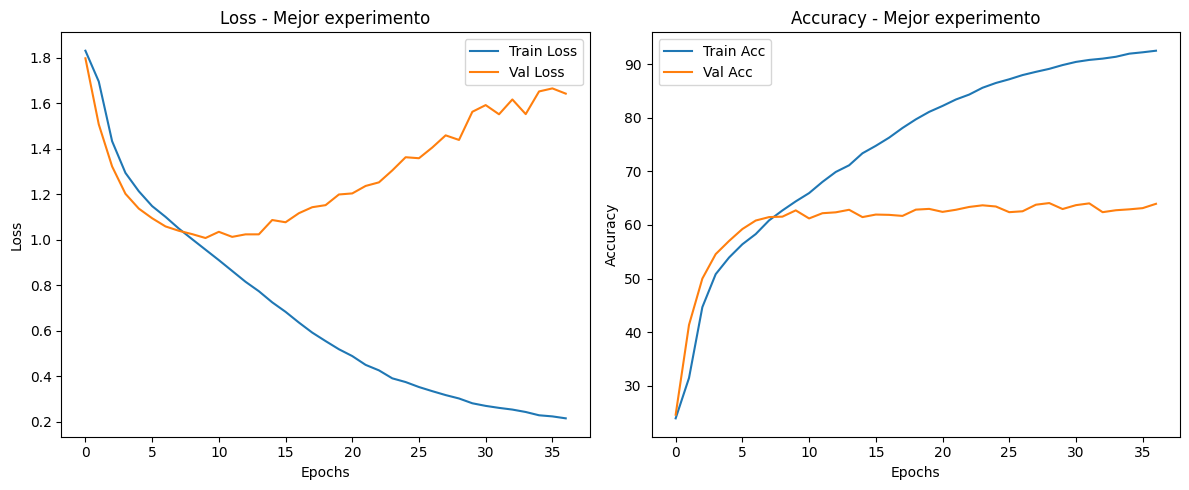

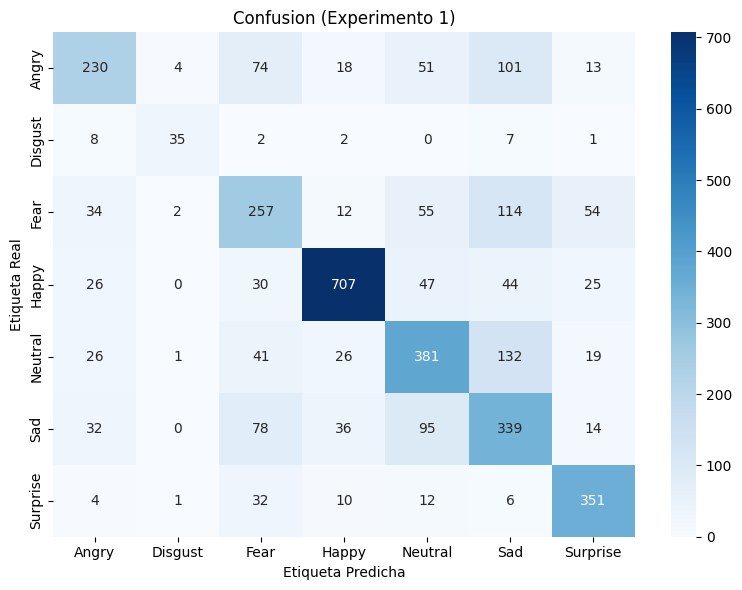

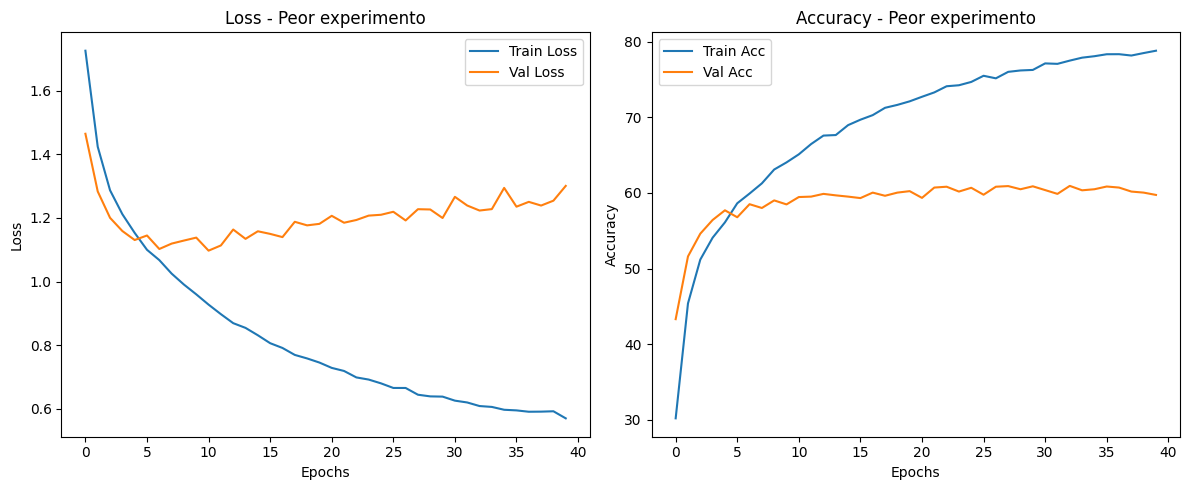

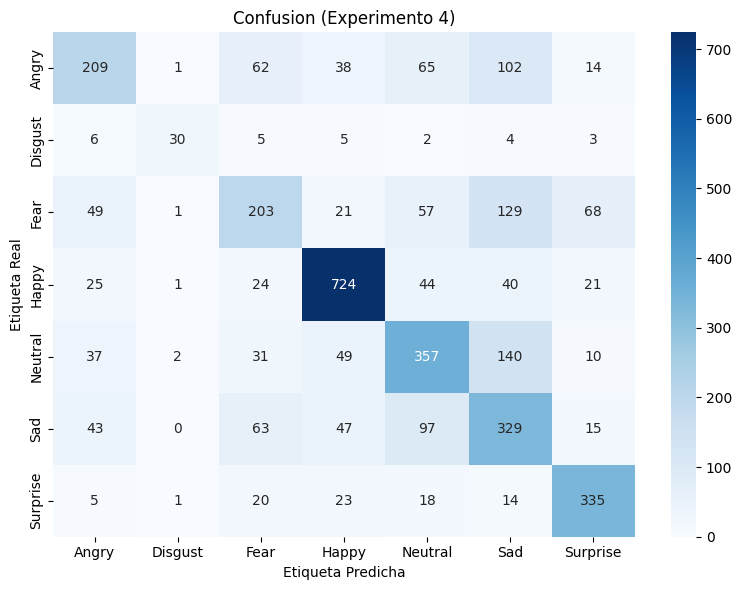

✅ Análisis completado.


In [99]:
dataset_path = kagglehub.dataset_download("pankaj4321/fer-2013-facial-expression-dataset")
BATCH_SIZE = 64
COLOR_MODE = "grayscale"

train_loader, val_loader, test_loader, classes = prepare_dataloaders(
        dataset_path,
        batch_size=BATCH_SIZE,
        img_size=(48, 48),
        color_mode=COLOR_MODE
    )    

try:
    print("Iniciando análisis...")
    analyze_from_csv("resultados_cnn_fer.csv", classes)
    print("✅ Análisis completado.")
except Exception as e:
    print(f"❌ Error durante el análisis: {e}")